In [43]:
#Installing new libraries, random commands

#!pip install wordcloud
#!pip install TextBlob
#!pip install xgboost
#!pip install lightgbm
#print(sys.executable)

In [44]:
#Packages Required

#Basic
import pandas as pd
import numpy as np
import os
import sys
import warnings
#warnings.filterwarnings("ignore")

#Data Viz
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from collections import Counter

#Text Processing
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

#ML
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

In [45]:
#Importing Data
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
df.shape

(23486, 11)

In [46]:
#Understand data structure
df.info() # need to drop the index 0 column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
Unnamed: 0                 23486 non-null int64
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [49]:
df.head()

Age                    Title  \
0   33                      NaN   
1   34                      NaN   
2   60  Some major design flaws   
3   50         My favorite buy!   
4   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Intimate  Intimates  
1                        4         General         Dresses    Dresses  
2                        0         General         Dresses    Dresses  
3                        0  General Petite         Bottoms      Pants  
4                        6         General            Tops    Blouses

In [47]:
#Preprocessing of df
#drop the index column and clothing id as it is not needed

df.drop(df.columns[[0,1]],inplace=True, axis=1) # inplace=True returns None and not a copy of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 9 columns):
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(4), object(5)
memory usage: 1.6+ MB


In [48]:
#Check for missing values
df.isnull().sum()

#Review Text has the maximum number of missing values, followed by Div Name, Dept Name and Class Name equally

Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [5]:
#Now, to understand the general trend of length of reviews, a length column will help with that

df['Review Length'] = df['Review Text'].astype(str).apply(len)

In [6]:
#I have considered a rating of 3 and above as positive ie 1 and 
# a rating of 2 and below as negative ie 0

df['Perception of Product'] = np.where(df['Rating'] >= 3, 1, 0)

In [7]:
#Remove missing values particularly from division name, class name, dept name as it wont aid in analysis.

#The review text column needs to be complete, hence missing values in those are dropped as well

#Title wont be for ML modeling, hence the column will be dropped altogether before ML modeling

for column in ["Class Name","Department Name","Division Name","Review Text"]:
    df = df[df[column].notnull()]
df.isnull().sum() #no more missing values in important columns for analysis

Age                           0
Title                      2966
Review Text                   0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                 0
Department Name               0
Class Name                    0
Review Length                 0
Perception of Product         0
dtype: int64

In [596]:
#Check for unique values
df.nunique()

Age                           77
Title                      13983
Review Text                22621
Rating                         5
Recommended IND                2
Positive Feedback Count       82
Division Name                  3
Department Name                6
Class Name                    20
Review Length                497
Perception of Product          2
dtype: int64

**EDA**


In [548]:
df.describe() #describing new df

Age        Rating  Recommended IND  Positive Feedback Count  \
count  22628.000000  22628.000000     22628.000000             22628.000000   
mean      43.282880      4.183092         0.818764                 2.631784   
std       12.328176      1.115911         0.385222                 5.787520   
min       18.000000      1.000000         0.000000                 0.000000   
25%       34.000000      4.000000         1.000000                 0.000000   
50%       41.000000      5.000000         1.000000                 1.000000   
75%       52.000000      5.000000         1.000000                 3.000000   
max       99.000000      5.000000         1.000000               122.000000   

       Review Length  Perception of Product  
count   22628.000000           22628.000000  
mean      308.761534               0.895263  
std       143.934126               0.306222  
min         9.000000               0.000000  
25%       186.000000               1.000000  
50%       302.000000               1.000000  
75%       459.000000               1.000000  
max       508.000000               1.000000

**Visualization**

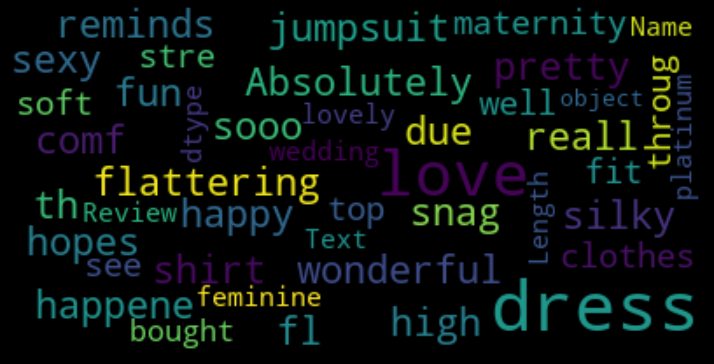

In [549]:
#Word Cloud for Review Text
import matplotlib as mpl
#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=12
                         ).generate(str(df['Review Text']))

fig = plt.figure(figsize=size, dpi=70, facecolor='k',edgecolor='k')
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

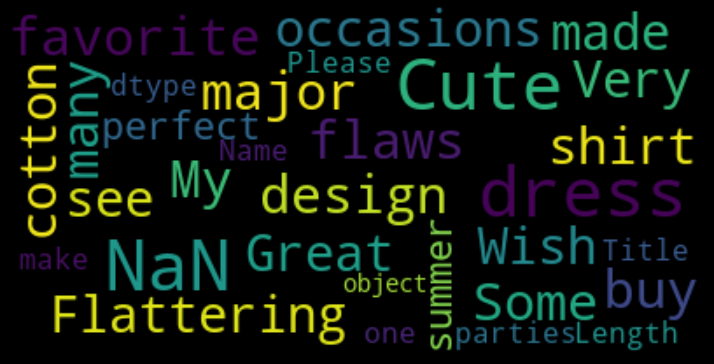

In [550]:
#Word Cloud for Title
import matplotlib as mpl
#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=12
                         ).generate(str(df['Title']))

fig = plt.figure(figsize=size, dpi=70, facecolor='k',edgecolor='k')
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

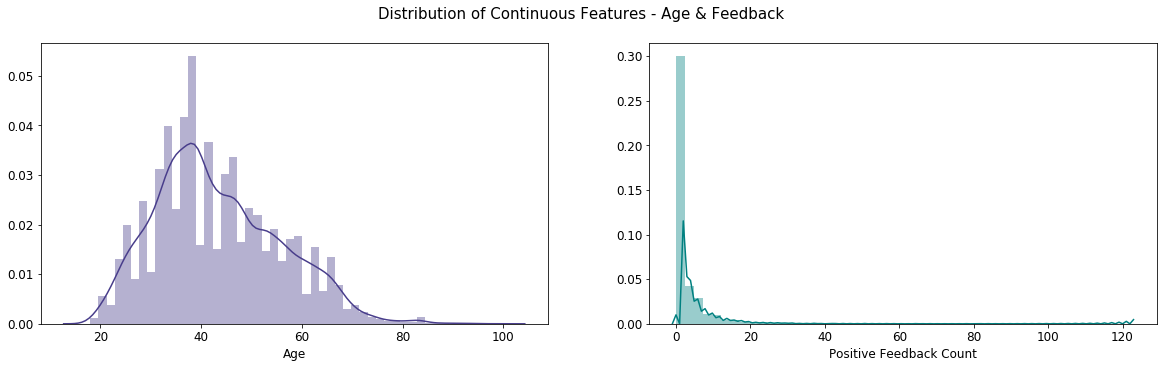

In [551]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(df["Age"], color="darkslateblue", ax=ax[0])
sns.distplot(df["Positive Feedback Count"], color = 'teal', ax=ax[1])
fig.suptitle('Distribution of Continuous Features - Age & Feedback', fontsize=15);

From the distribution of Categorical Variables, it can be seen the the data set is unbalanced as "Recommended IND" has more people recommedning a product that people who dont recommend it.

Hence I shall be using PROCC to understand the ML models better.

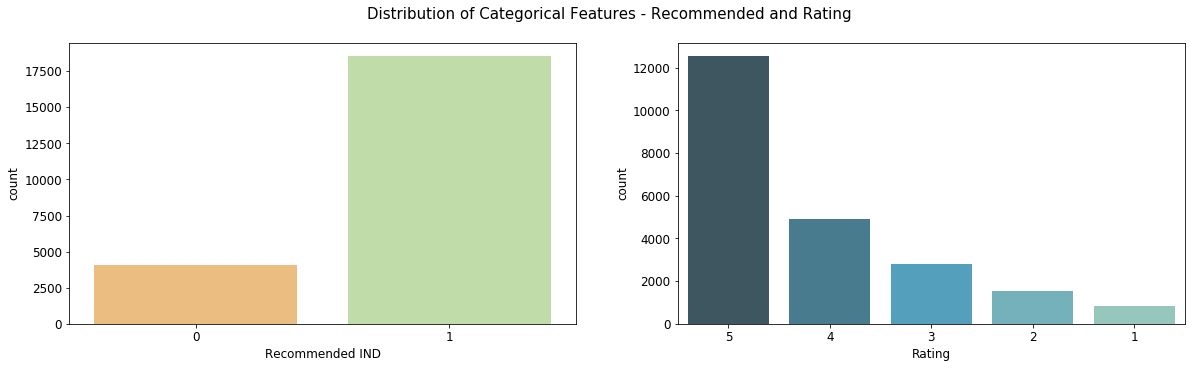

In [552]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.catplot(x="Recommended IND", kind = "count", palette=("Spectral"), data = df, ax=ax[0])
sns.catplot(x="Rating", kind = "count", palette=("GnBu_d"), data = df, order = df.Rating.value_counts().index, ax=ax[1])
fig.suptitle('Distribution of Categorical Features - Recommended and Rating', fontsize=15);
for i in range(2,4): 
    plt.close(i)

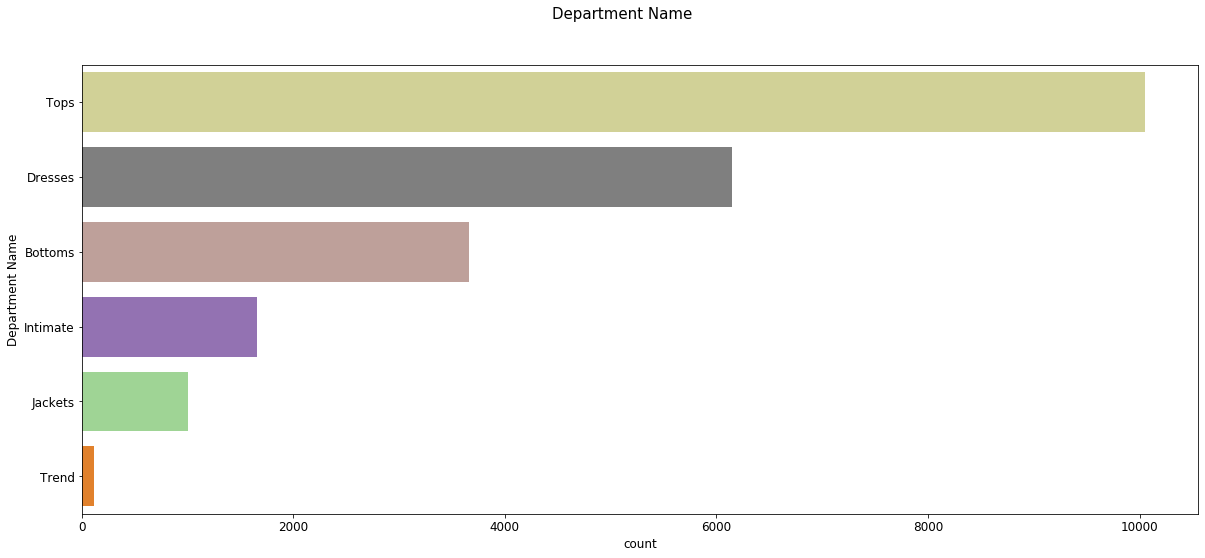

In [553]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.countplot(y="Department Name", palette = "tab20_r",data=df, order=df["Department Name"].value_counts().index)
fig.suptitle('Department Name', fontsize=15);

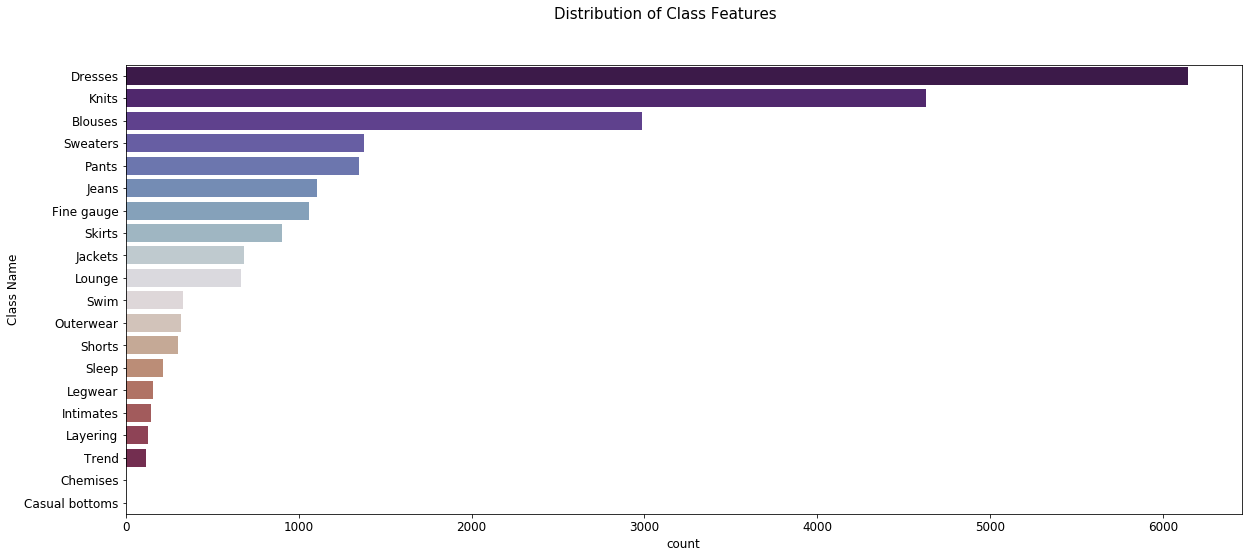

In [555]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.countplot(y="Class Name", palette = "twilight_shifted", data=df, order=df["Class Name"].value_counts().index)
fig.suptitle('Distribution of Class Features', fontsize=15);

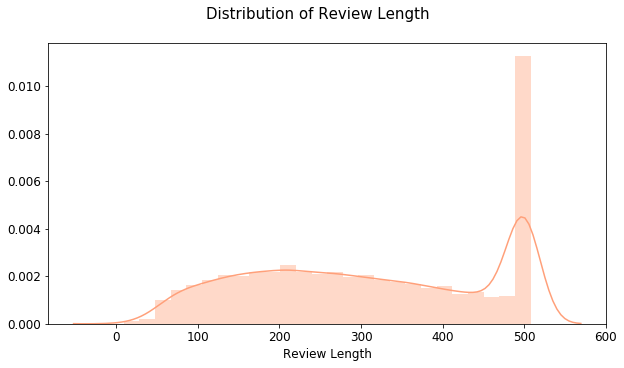

In [556]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.distplot(df['Review Length'], color = "lightsalmon")
fig.suptitle('Distribution of Review Length', fontsize=15);

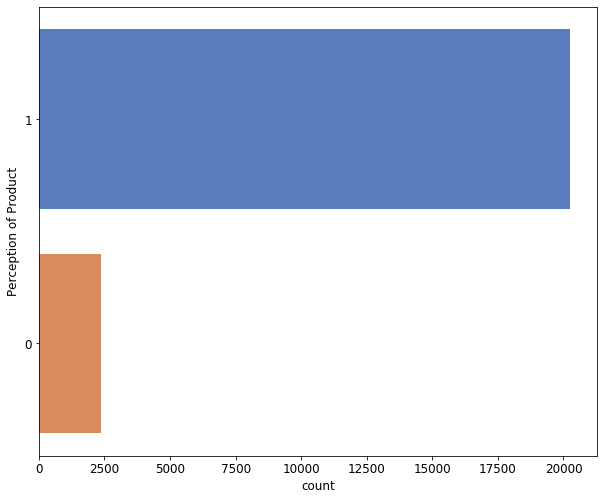

In [557]:
plt.figure(figsize=(10,8))
sns.countplot(y =df['Perception of Product'], palette = "muted", data = df, order=df["Perception of Product"].value_counts().index);

From the chart below, it can be seen that the users who gave a rating of 5 often, often wrote 500 plus word length reviews

<Figure size 720x360 with 0 Axes>

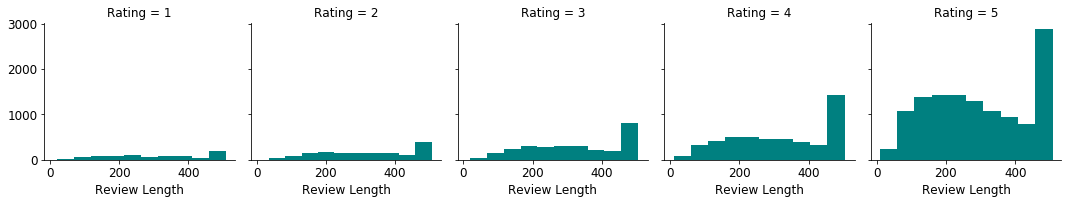

In [559]:
plt.figure(figsize=(10,5))
g = sns.FacetGrid(data=df, col='Rating')
g.map(plt.hist, 'Review Length', color = "teal", bins=10);

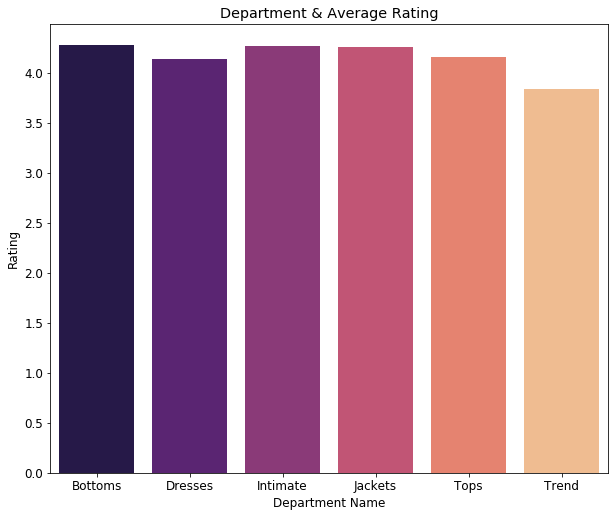

In [560]:
reco = df.groupby('Department Name', as_index=False).mean()[['Department Name','Rating']]
reco
plt.figure(figsize=(10,8))
plt.title("Department & Average Rating")
chart = sns.barplot(x='Department Name', y='Rating',data = reco,palette = "magma")

**Polarity**

A product represents the tone of the review or the sentiment as negative, positive and neutral tone.

Sentiment Polarity

TextBlob uses a sentiment lexicon (consisting of predefined words) to assign scores for each word, which are then averaged out using a weighted average to give an overall sentence sentiment score. Three scores: “polarity”, “subjectivity” and “intensity” are calculated for each word.

Each word in the lexicon has scores for:

    1. polarity: negative vs. positive    (-1.0 => +1.0)
    2. subjectivity: objective vs. subjective (+0.0 => +1.0)
    3. intensity: modifies next word?      (x0.5 => x2.0)
    
   Eg : TextBlob("great").sentiment #Sentiment(polarity=0.8, subjectivity=0.75)
   
   TextBlob("not great").sentiment #Sentiment(polarity=-0.4, subjectivity=0.75)
   
Recognizing “very” as a modifier word, TextBlob will ignore polarity and subjectivity and just use intensity to modify the following word: 

TextBlob("very great").sentiment #Sentiment(polarity=1.0, subjectivity=0.9750000000000001)

The polarity gets maxed out at 1.0, but you can see that subjectivity is also modified by “very” to become 
0.75 x 1.3 =0.975

A sizeable number of samples belong to the neutral class. It is clear that our TextBlob classifier predicts most samples as neutral

Very few predictions are strongly negative or positive — this makes sense because TextBlob uses a weighted average sentiment score over all the words in each sample.

In [8]:
# Defining a sentiment analyser function
def sentiment_analyser(review):
    return review.apply(lambda Text: pd.Series(TextBlob(Text).sentiment.polarity))

In [9]:
# Applying function to reviews
df['Polarity'] = sentiment_analyser(df['Review Text'])
df.sample(5)

Age              Title  \
2576    24  Unique and so fun   
2076    60      Super sweater   
8482    53      Great quality   
17021   38                NaN   
1571    43                NaN   

                                             Review Text  Rating  \
2576   I was drawn to these pants because i loved the...       5   
2076   This will be a favorite sweater this winter. i...       5   
8482   I bought this top in black n moss. they are of...       3   
17021  I agree with previous review...looks so much b...       4   
1571   These are some of my favorite new pants. i am ...       5   

       Recommended IND  Positive Feedback Count   Division Name  \
2576                 1                        3         General   
2076                 1                        1         General   
8482                 1                        0         General   
17021                1                        1         General   
1571                 1                        2  General Petite   

      Department Name  Class Name  Review Length  Perception of Product  \
2576          Bottoms       Pants            500                      1   
2076             Tops  Fine gauge            500                      1   
8482             Tops       Knits            384                      1   
17021            Tops       Knits            182                      1   
1571          Bottoms       Pants            162                      1   

       Polarity  
2576   0.384028  
2076   0.134741  
8482   0.340833  
17021  0.339583  
1571   0.320671

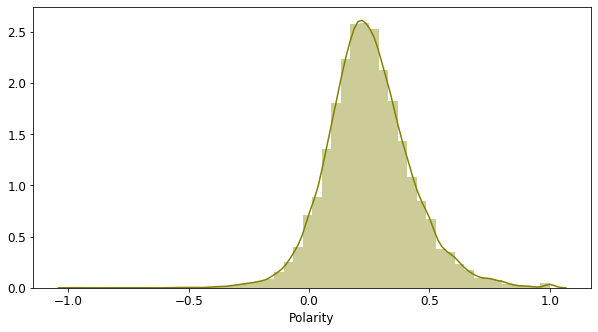

In [725]:
plt.figure(figsize=(10,5))
sns.distplot(df['Polarity'], color = 'olive');

Understanding how different polarities work across texts

In [600]:
pol = df.loc[df.Polarity == 1,['Review Text']].sample(5).values #Positive
pol

array([['Great purchase! i bought the coat to wear to work.'],
       ['Made my wedding outfit perfect!'],
       ["Perfect! can't believe how inexpensive this is for the look. it looks just like it does on the model. i can't wait to wear it on my vacation."],
       ["I've been looking for an off the should sweater like this for over a year! looks great on and doesn't itch! can't wait for fall so i can wear it!"],
       ["Absolutely gorgeous!\r\nwords can't describe the beauty of this dress!\r\ni hope they will restock it cause i would order size s (didn't know how it runs)."]],
      dtype=object)

In [601]:
pol = df.loc[df.Polarity == 0.5,['Review Text']].sample(5).values #Neutral
pol

array([["I love these pants and wear them all the time. i wish they hadn't been discontinued"],
       ['Love this top. fits me perfect. i am bigger on top and received many compliments in this shirt.'],
       ['Love this. can be a jacket or blazer syle. fits well.'],
       ['The dress i received is adorable, however, the color is much more subdued than shown in the catalog.'],
       ['I disagree with the most recent review! they are legging style fit but not leggings at all! they are a jean style with a patterning on them a texture.\r\ngreat colors!']],
      dtype=object)

In [602]:
pol =  df.loc[df.Polarity <0,['Review Text']].sample(5).values #Neutral
pol

array([['I was so excited to buy it online, but it come in a small plastic bag, and lot of pieces are missing on the one i got, so i had to return it'],
       ["Like this top. it's not too thin but still remains cool. too bad it has to be hand washed."],
       ["I tried this blouse on in the store. i'm generally an 8 or 10 in this brand. i got down to a size 4 and gave up. this blouse is huge all the way around. the detail on the blouse is pretty, but the tent like cut made it impossible for me to buy it. i know retailers blouses can be swingy and flows but this went way beyond. perhaps on a tall person the swing would work but on a short person like myself...i looked ridiculous."],
       ["I bought this dress at my local retailer store on friday and love it! the dress is well made, with some heft to the yarn. the colors of the yarn, blue, white and grey, seem to shimmer a bit due to their weave, but there is no metallic thread in the dress that i can tell. i know some have written 

In [570]:
#Plotting Polarity

neg = sum(1 for i in df.Polarity if i<0) 
pos = sum(1 for i in df.Polarity if i>0.5) 
neu = sum(1 for i in df.Polarity if i>0) 

data = {'Negative':[neg], 'Neutal':[neu], 'Positive':[pos]}

poldf = pd.DataFrame(data) 
poldf

Negative  Neutal  Positive
0      1322   21214      1669

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  after removing the cwd from sys.path.


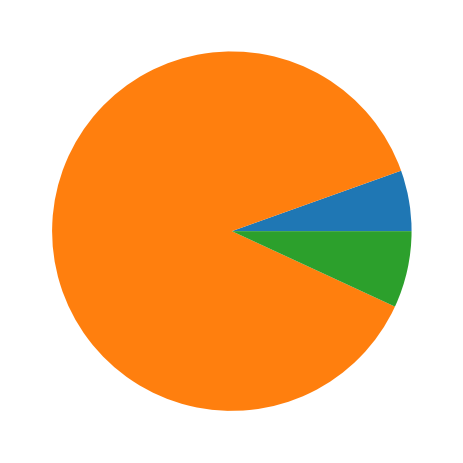

In [603]:
plt.figure(figsize =(10, 8)) 
#plt.pie([pos,neg,neu], labels = ['Positive','Negative','Neutral']);

plt.pie(poldf);

In [604]:
#Length vs Polarity Chart MAKE

Text Processing


n CountVectorizer we only count the number of times a word appears in the document which results in biasing in favour of most frequent words. this ends up in ignoring rare words which could have helped is in processing our data more efficiently.

To overcome this , we use TfidfVectorizer .

In TfidfVectorizer we consider overall document weightage of a word. It helps us in dealing with most frequent words. Using it we can penalize them. TfidfVectorizer weights the word counts by a measure of how often they appear in the documents.


The scikit-learn library offers easy-to-use tools to perform both tokenization and feature extraction of your text data.

How to convert text to word count vectors with CountVectorizer.

Bag-of-Words Model
We cannot work with text directly when using machine learning algorithms.

Instead, we need to convert the text to numbers.

Algorithms take vectors of numbers as input, therefore we need to convert documents to fixed-length vectors of numbers.

This can be done by assigning each word a unique number. Then any document we see can be encoded as a fixed-length vector with the length of the vocabulary of known words. The value in each position in the vector could be filled with a count or frequency of each word in the encoded document.

Word Counts with CountVectorizer
The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

You can use it as follows:

Create an instance of the CountVectorizer class.
Call the fit() function in order to learn a vocabulary from one or more documents.
Call the transform() function on one or more documents as needed to encode each as a vector.
Above two steps can be merged to one step

An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.

https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

https://kavita-ganesan.com/how-to-use-countvectorizer/#Example-of-How-CountVectorizer-Works

 By default, CountVectorizer does the following:

- lowercases your text (set lowercase=false if you don’t want lowercasing)
- uses utf-8 encoding
- performs tokenization (converts raw text to smaller units of text)
- uses word level tokenization (meaning each word is treated as a separate token)
- ignores single characters during tokenization (say goodbye to words like ‘a’ and ‘I’)

The reason why stop words are critical to many applications is that, if we remove the words that are very commonly used in a given language, we can focus on the important words instead. 

The vectors returned from a call to transform() will be sparse vectors, and you can transform them back to numpy arrays to look and better understand what is going on by calling the toarray() function.hese vectors will contain a lot of zeros, we call them sparse.


The encoded vectors can then be used directly with a machine learning algorithm.


Now, the first thing you may want to do, is to eliminate stop words from your text as it has limited predictive power and may not help with downstream tasks such as text classification. Stop word removal is a breeze with CountVectorizer and it can be done in several ways:

- Use a custom stop word list that you provide
- Use sklearn’s built in English stop word list (not recommended)
- Create corpora specific stop words using max_df and min_df (highly recommended and will be covered later in this tutorial)

use of n-grams is for developing features for supervised Machine Learning models such as SVMs, MaxEnt models, Naive Bayes, etc.


In [10]:
#Adding the word counts to a dataframe is a very good practice because we might use these counts to reach some useful information. 

#create transform fn with CountVectorizer() class
vectorizer = CountVectorizer()

#Return a callable that handles preprocessing, tokenization and n-grams generation.
#build_analyzer() returns a callable that let's you extract the tokenizing step from the transformation pipeline wrapped in the CountVectorizer
#applies preprocessing, tokenization, remove stop words and creates n-grams.
analyze = vectorizer.build_analyzer()
# Eg : [u'this', u'is', u'text', u'document', u'to', u'analyze']

def count_of_words(x):
    a = {}
    # tokenize the string and continue, if it is not empty
    if analyze(x):
        b = {}
        
        #This is equivalent to fit followed by transform, but more efficiently implemented.
        c = vectorizer.fit_transform([x]).toarray()
        # vocabulary and index
        d = vectorizer.vocabulary_
        # items() transforms the dictionary's (word, index) tuple pairs
        for y,z in d.items():
            b[z]=y # index:word 
        for index,i in enumerate(c[0]):
            a[b[index]] = i # word:count
    return  a

# add new column to the dataframe
df['Count of Words'] = df['Review Text'].apply(count_of_words)
df.head(3)

Age                    Title  \
0   33                      NaN   
1   34                      NaN   
2   60  Some major design flaws   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   

   Positive Feedback Count Division Name Department Name Class Name  \
0                        0     Initmates        Intimate  Intimates   
1                        4       General         Dresses    Dresses   
2                        0       General         Dresses    Dresses   

   Review Length  Perception of Product  Polarity  \
0             53                      1  0.633333   
1            303                      1  0.339583   
2            500                      1  0.073675   

                                      Count of Words  
0  {'absolutely': 1, 'and': 2, 'comfortable': 1, ...  
1  {'am': 1, 'and': 2, 'bc': 2, 'be': 1, 'below':...  
2  {'and': 3, 'be': 1, 'bottom': 1, 'but': 2, 'ch...

In [585]:
def top_n_ngram(corpus,n = None,ngram = 1):
    vec = CountVectorizer(stop_words = 'english',ngram_range=(ngram,ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus) #Have the count of  all the words for each review
    sum_words = bag_of_words.sum(axis =0) #Calculates the count of all the word in the whole review
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse = True)
    return words_freq[:n]

In [586]:
common_words = top_n_ngram(df['Review Text'], 20,1)
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
plt.figure(figsize =(10,5))
df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
kind='bar', title='Top 20 unigrams in review after removing stop words')

KeyError: 'Review Text'

**Model Fitting Begins**

1. Split the data

In [11]:
X = vectorizer.fit_transform(df['Review Text'])

In [12]:
y = df['Perception of Product']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
print('Train/Test Size : ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Train/Test Size :  (16971, 14144) (5657, 14144) (16971,) (5657,)


In [614]:
#IGNORE

# split data
#train_data,test_data = train_test_split(df,train_size=0.75,random_state=12)

#The text must be parsed to remove words, called tokenization. Then the words need to be encoded as integers or floating point values for use as input to a machine learning algorithm, called feature extraction (or vectorization).
#X_train = vectorizer.fit_transform(train_data['Review Text'])
#y_train = train_data['Perception of Product']
#X_test = vectorizer.transform(test_data['Review Text'])
#y_test = test_data['Perception of Product']

**Logistic Regression**

In [730]:
#Fitting Logistic Regression Model
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

The accuracy score is 90.3


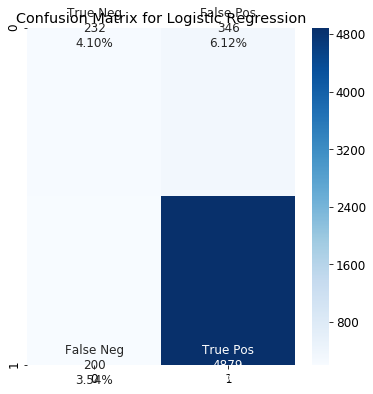

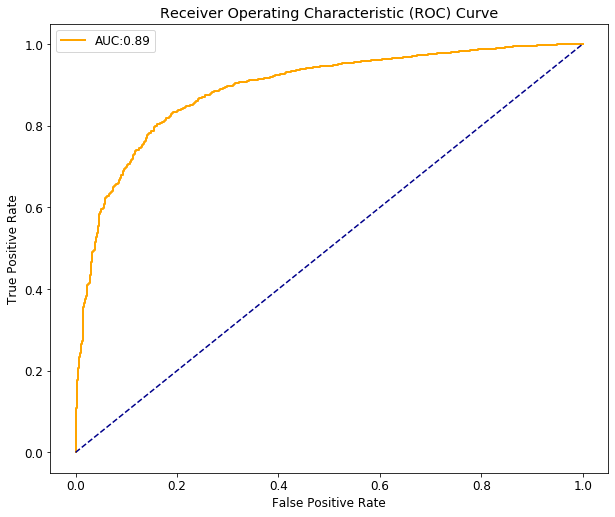

Classification Report:  
               precision    recall  f1-score   support

           0       0.54      0.40      0.46       578
           1       0.93      0.96      0.95      5079

    accuracy                           0.90      5657
   macro avg       0.74      0.68      0.70      5657
weighted avg       0.89      0.90      0.90      5657



In [738]:
#Accuracy Score
lr_score = accuracy_score(y_test,lr.predict(X_test))
print('The accuracy score is ' + str(round(lr_score,3)*100))

#Confusion Matrix
lr_matrix=confusion_matrix(y_test.values,lr.predict(X_test))
plt.figure(figsize=(6,6))
plt.title("Confusion Matrix for Logistic Regression")
#Plotting CF : From https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                lr_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     lr_matrix.flatten()/np.sum(lr_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lr_matrix, annot=labels, fmt='', cmap='Blues');

#ROC Curve
predict_lr = lr.predict_proba(X_test)[:,1]
fp_lr,tp_lr,th = roc_curve(y_test,predict_lr)
auc_lr = auc(fp_lr,tp_lr)

# Plotting the true positive and false positive rate
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label="AUC:%.2f" % (auc_lr), linewidth=2, c='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
plot_roc_curve(fp_lr, tp_lr)

#Classification Report
print("Classification Report:  \n",classification_report(y_test,lr.predict(X_test)))

**Lasso Regression**

FIX THIS

In [25]:
ls= LogisticRegression(penalty = 'l1', solver ='liblinear')
ls.fit(X_train,y_train)
print(ls)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


The accuracy score is 90.60000000000001


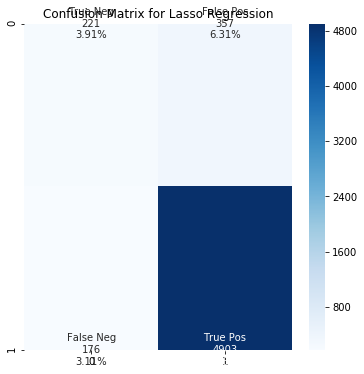

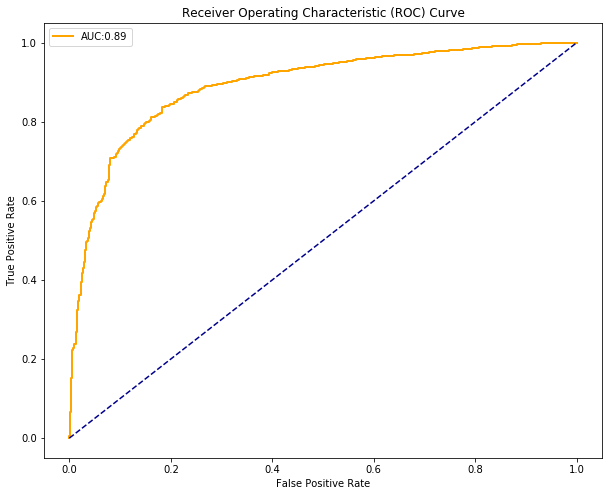

Classification Report:  
               precision    recall  f1-score   support

           0       0.56      0.38      0.45       578
           1       0.93      0.97      0.95      5079

    accuracy                           0.91      5657
   macro avg       0.74      0.67      0.70      5657
weighted avg       0.89      0.91      0.90      5657



In [30]:
#Accuracy Score
ls_score = accuracy_score(y_test,ls.predict(X_test))
print('The accuracy score is ' + str(round(ls_score,3)*100))


#Confusion Matrix
ls_matrix=confusion_matrix(y_test.values,ls.predict(X_test))
plt.figure(figsize=(6,6))
plt.title("Confusion Matrix for Lasso Regression")
#Plotting CF : From https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                ls_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     ls_matrix.flatten()/np.sum(ls_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(ls_matrix, annot=labels, fmt='', cmap='Blues');

#ROC Curve
predict_ls = ls.predict_proba(X_test)[:,1]
fp_ls,tp_ls,th = roc_curve(y_test,predict_ls)
auc_ls = auc(fp_ls,tp_ls)

# Plotting the true positive and false positive rate
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label="AUC:%.2f" % (auc_ls), linewidth=2, c='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
plot_roc_curve(fp_ls, tp_ls)

#Classification Report
print("Classification Report:  \n",classification_report(y_test,ls.predict(X_test)))


**Multinomial Naive Bayes**

The general term Naive Bayes refers the the strong independence assumptions in the model, rather than the particular distribution of each feature.

Multinomial Naive Bayes classifier is a specific instance of a Naive Bayes classifier which uses a multinomial distribution for each of the features.


In [741]:
#Fitting Naive Bayes Model
nb = MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

The accuracy score is 90.60000000000001


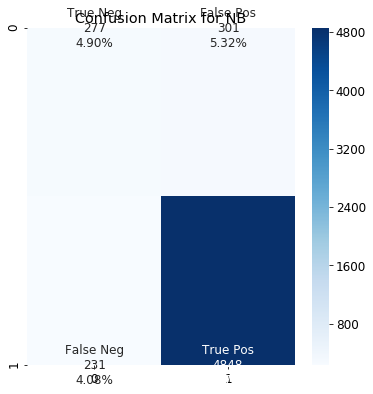

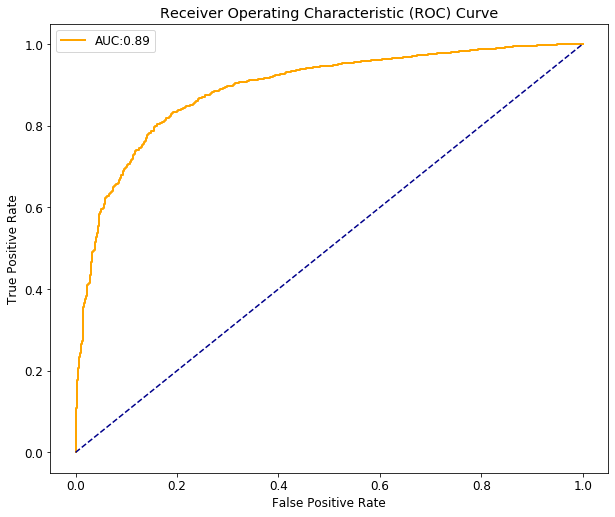

Classification Report:  
               precision    recall  f1-score   support

           0       0.55      0.48      0.51       578
           1       0.94      0.95      0.95      5079

    accuracy                           0.91      5657
   macro avg       0.74      0.72      0.73      5657
weighted avg       0.90      0.91      0.90      5657



In [747]:
#Accuracy Score
nb_score = accuracy_score(y_test,nb.predict(X_test))
print('The accuracy score is ' + str(round(nb_score,3)*100))

#Confusion Matrix
nb_matrix=confusion_matrix(y_test.values,nb.predict(X_test))
plt.figure(figsize=(6,6))
plt.title("Confusion Matrix for NB")
#Plotting CF : From https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                nb_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     nb_matrix.flatten()/np.sum(nb_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(nb_matrix, annot=labels, fmt='', cmap='Blues');

#ROC Curve
predict_nb = nb.predict_proba(X_test)[:,1]
fp_nb,tp_nb,th = roc_curve(y_test,predict_nb)
auc_nb = auc(fp_nb,tp_nb)

# Plotting the true positive and false positive rate
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label="AUC:%.2f" % (auc_nb), linewidth=2, c='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
plot_roc_curve(fp_nb, tp_nb)

#Classification Report
print("Classification Report:  \n",classification_report(y_test,nb.predict(X_test)))

**SVM**


In [748]:
#Fitting Support Vector Machine Model
sv = SVC()
sv.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

The accuracy score is 89.8


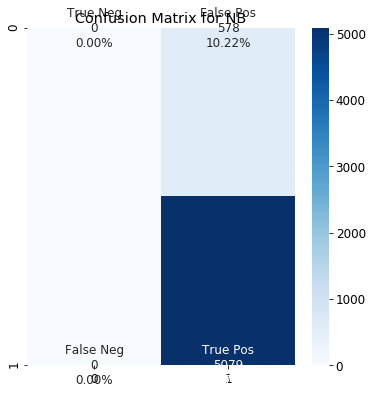

In [751]:
#Accuracy Score
sv_score = accuracy_score(y_test,sv.predict(X_test))
print('The accuracy score is ' + str(round(sv_score,3)*100))

#Confusion Matrix
sv_matrix=confusion_matrix(y_test.values,sv.predict(X_test))
plt.figure(figsize=(6,6))
plt.title("Confusion Matrix for NB")
#Plotting CF : From https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                sv_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     sv_matrix.flatten()/np.sum(sv_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(sv_matrix, annot=labels, fmt='', cmap='Blues');

#ROC Curve
predict_sv = sv.decision_function(X_test)
fp_sv,tp_sv,th = roc_curve(y_test,predict_sv)
auc_sv = auc(fp_sv,tp_sv)

# Plotting the true positive and false positive rate
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label="AUC:%.2f" % (auc_sv), linewidth=2, c='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
plot_roc_curve(fp_sv, tp_sv)

#Classification Report
print("Classification Report:  \n",classification_report(y_test,sv.predict(X_test)))

**Random Forest**

In [756]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [758]:
#Accuracy Score
rf_score = accuracy_score(y_test,rf.predict(X_test))
print('The accuracy score is ' + str(round(rf_score,3)*100))

The accuracy score is 90.0


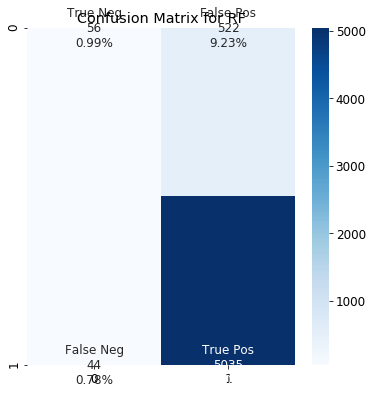

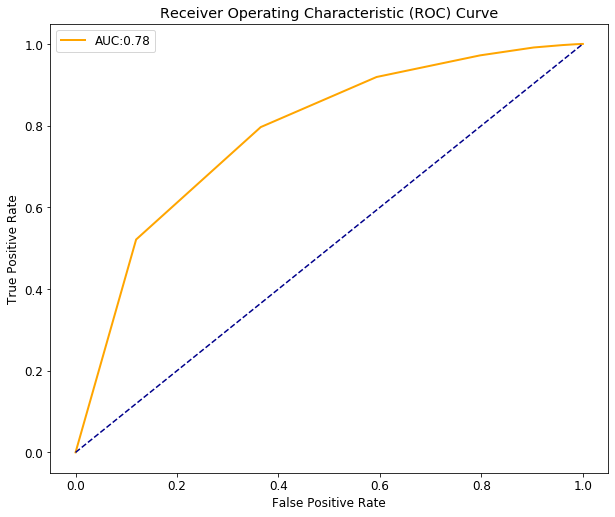

Classification Report:  
               precision    recall  f1-score   support

           0       0.56      0.10      0.17       578
           1       0.91      0.99      0.95      5079

    accuracy                           0.90      5657
   macro avg       0.73      0.54      0.56      5657
weighted avg       0.87      0.90      0.87      5657



In [761]:
#Confusion Matrix
rf_matrix=confusion_matrix(y_test.values,rf.predict(X_test))
plt.figure(figsize=(6,6))
plt.title("Confusion Matrix for RF")
#Plotting CF : From https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                rf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     rf_matrix.flatten()/np.sum(rf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(rf_matrix, annot=labels, fmt='', cmap='Blues');

#ROC Curve
predict_rf = rf.predict_proba(X_test)[:,1]
fp_rf,tp_rf,th = roc_curve(y_test,predict_rf)
auc_rf = auc(fp_rf,tp_rf)

# Plotting the true positive and false positive rate
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label="AUC:%.2f" % (auc_rf), linewidth=2, c='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
plot_roc_curve(fp_rf, tp_rf)

#Classification Report
print("Classification Report:  \n",classification_report(y_test,rf.predict(X_test)))

In [35]:
!pip install lightgbm

In [290]:
dress_mask = np.array(Image.open("dress.png"))
dress_mask

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [293]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [295]:
transformed_dress_mask = np.ndarray((dress_mask.shape[0],dress_mask.shape[1]), np.int32)

for i in range(len(dress_mask)):
    transformed_dress_mask[i] = list(map(transform_format, dress_mask[i]))
    
transformed_dress_mask

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [313]:
from collections import Counter 
Counter = Counter(df['Title']) 
most_occur = Counter.most_common(4) 
print(most_occur) 

[(nan, 3810), ('Love it!', 136), ('Beautiful', 95), ('Love', 88)]
